In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.wcs import wcs, Sip
import astropy.units as u

In [2]:
t = ascii.read("distort.dat")

In [3]:
def solve_linear_equation(a, b):
    q, r = np.linalg.qr(a)
    y = np.dot(q.T, b)
    x = np.linalg.solve(r, y)
    return x

In [4]:
ra0, dec0 = np.mean(t["ra"]), np.mean(t["dec"])
x0, y0 = 1548, 1040
dx, dy = t["x"]-x0, t["y"]-y0

order = 3
ixs, iys = np.meshgrid(np.arange(order+1), np.arange(order+1))
c=ixs+iys<=order
ix, iy = ixs[c], iys[c]

a = np.array([dx**ix[i]*dy**iy[i] for i in range(len(iy))]).T

for k in range(5):
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
    w.wcs.cd = [[1.0, 0.0], [0.0, 1.0]]
    w.wcs.crval = [ra0, dec0]
    w.wcs.crpix = [0.0, 0.0]

    p = w.wcs_world2pix(t["ra"], t["dec"], 1)
    rx, ry = p[0], p[1]
    
    ax = solve_linear_equation(a, rx)
    ay = solve_linear_equation(a, ry)

    print(ra0, dec0, ax[0], ay[0])
    
    ra0, dec0 = w.wcs_pix2world(([[ax[0], ay[0]]]), 1)[0]

273.2788727528016 32.98374466971185 2.8051814383748983 -0.4548932922528845
276.6052238952561 32.48465639275629 -0.017996422174846587 0.0038004367818625364
276.58388847272914 32.48845502992215 0.00011610021827079207 -2.6739962283572537e-05
276.5840261137795 32.48842828988496 -7.487256727975248e-07 1.8943545031924242e-07
276.58402522613784 32.48842847932041 4.826737252218535e-09 -1.3497214290667516e-09


In [5]:
print(len(ix))

10


In [6]:
cd = np.array([[ax[1], ax[order+1]], [ay[1], ay[order+1]]])
cdinv = np.linalg.inv(cd)

In [7]:
axm = np.zeros_like(ixs).astype("float32")
aym = np.zeros_like(ixs).astype("float32")
for i in range(len(ix)):
    if ix[i]+iy[i]>=2:
        p = np.matmul(cdinv, np.array([ax[i], ay[i]]))
        axm[iy[i], ix[i]] = p[0]
        aym[iy[i], ix[i]] = p[1]    

In [8]:
w = wcs.WCS(naxis=2)
w.wcs.ctype = ["RA---ZEA-SIP", "DEC--ZEA-SIP"]
w.wcs.cd = cd
w.wcs.crval = [ra0, dec0]
w.wcs.crpix = [x0, y0]
w.sip = Sip(axm.T, aym.T, None, None, w.wcs.crpix)

In [9]:
print(np.matrix(w.sip.a))

[[ 0.00000000e+00  0.00000000e+00  6.87911279e-06  4.03040046e-10]
 [ 0.00000000e+00 -3.13635314e-06  1.53627902e-08  0.00000000e+00]
 [ 4.84149905e-06  2.86159402e-10  0.00000000e+00  0.00000000e+00]
 [ 1.51749262e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [10]:
xp, yp = w.all_world2pix(np.stack((t["ra"], t["dec"]), axis=-1), 1).T

In [11]:
rap, decp = w.all_pix2world(np.stack((t["x"], t["y"]), axis=1), 1).T

In [12]:
# Class for the Tycho 2 catalog
class tycho2_catalog:
    """Tycho2 catalog"""

    def __init__(self, maxmag=9.0):
        hdu = fits.open("/home/bassa/code/python/satellite/astrometry-tycho2/build/tyc2.fits")

        ra = hdu[1].data.field('RA')*u.deg
        dec = hdu[1].data.field('DEC')*u.deg
        mag = hdu[1].data.field('MAG_VT')

        c = mag < maxmag
        self.ra = ra[c]
        self.dec = dec[c]
        self.mag = mag[c]
        self.x = np.empty(len(self.ra))
        self.y = np.empty(len(self.ra))
        self.flag = np.zeros(len(self.ra))

In [18]:
# Read image
img = plt.imread("/home/bassa/satobs/allsky/20190727/2019-07-27T22:08:17.116.jpg")

In [19]:
# Read catalog and compute x, y positions
ast = tycho2_catalog(6.0)
xp, yp = w.all_world2pix(np.stack((ast.ra, ast.dec), axis=-1), 1).T
mag = ast.mag
minmag, maxmag = -2, 5
minrad, maxrad = 1, 200
rad = np.interp(mag, [minmag, maxmag], [maxrad, minrad])

(0, 2080)

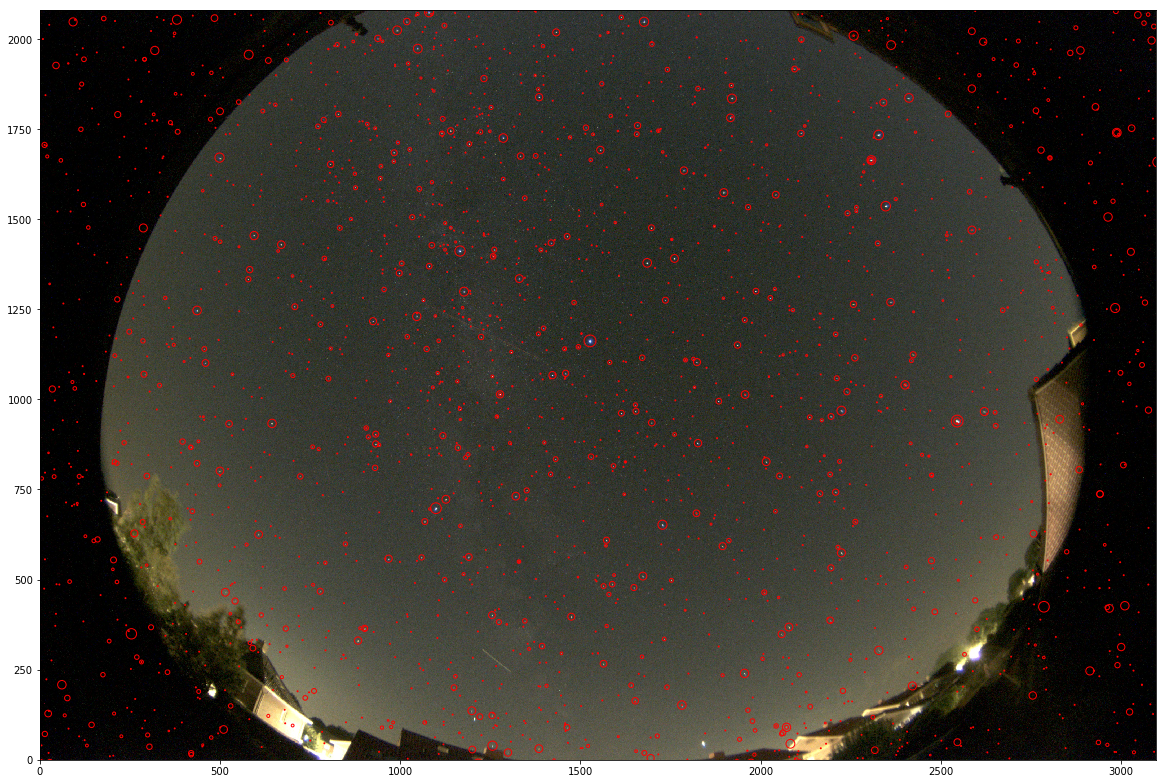

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(np.flipud(img), origin="lower")

ax.scatter(xp, yp, s=rad, marker="o", color="r", facecolors="None")
ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])

(0, 2080)

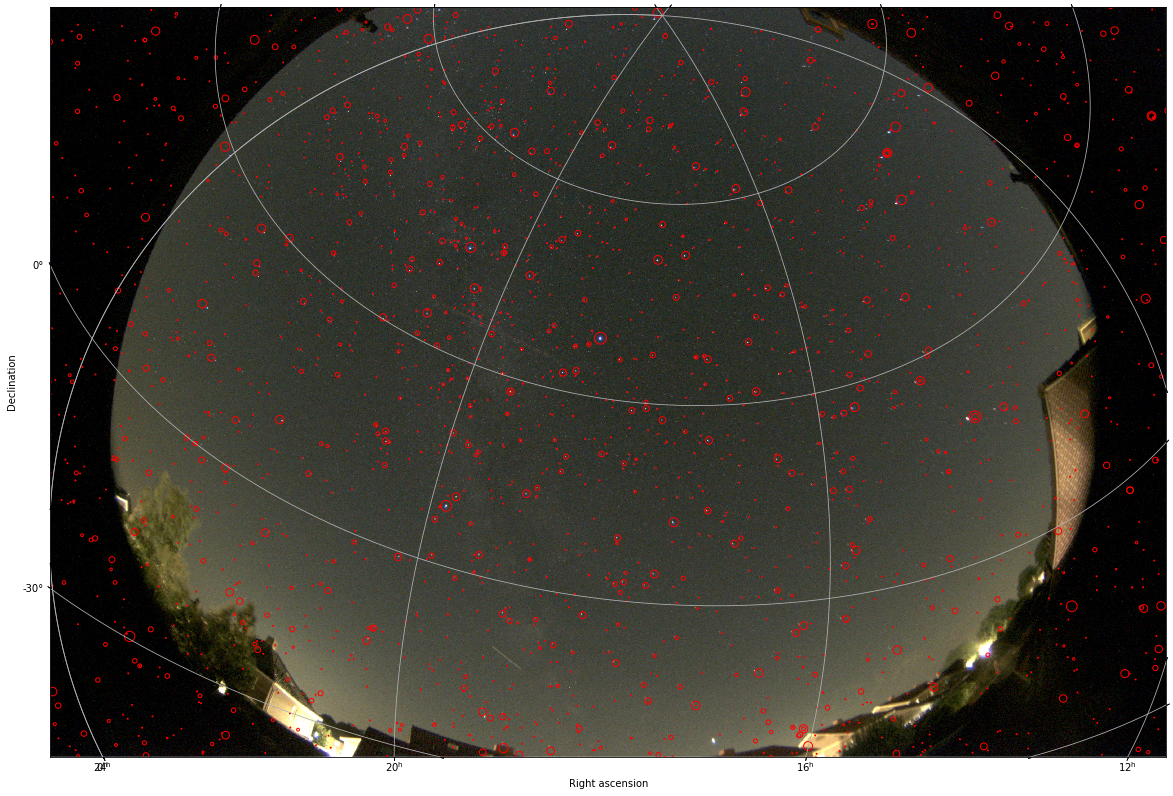

In [27]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection=w)
ax.imshow(np.flipud(img))
ax.set_xlabel("Right ascension")
ax.set_ylabel("Declination")
ax.grid()
ax.scatter(ast.ra, ast.dec, s=rad, transform=ax.get_transform("world"), marker="o", color="r", facecolors="None");
ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])

How big are the distortions?

In [61]:
p = np.meshgrid(np.arange(0, img.shape[1], 80), np.arange(0, img.shape[0], 80))
x, y = p[0].ravel(), p[1].ravel()

In [67]:
xd, yd = w.sip_pix2foc(x, y, 1)

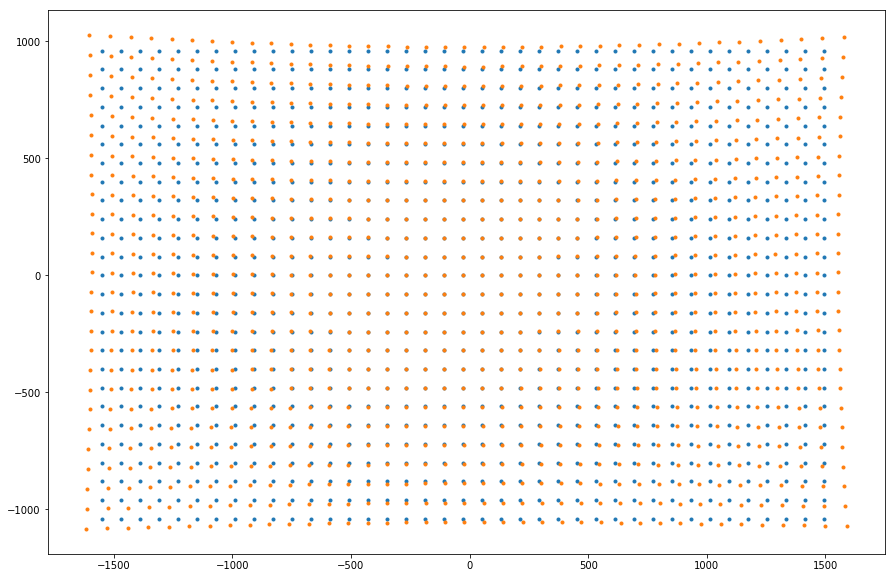

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x-x0, y-y0, ".")
ax.plot(xd, yd, ".")

In [68]:
hdu = fits.open("/home/bassa/satobs/allsky/20190727/2019-07-27T22:08:17.116.fits")
img = hdu[0].data
hdr = hdu[0].header
hdu.close()
print(hdr)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3096                                                  NAXIS2  =                 2080                                                  DATE-OBS= '2019-07-27T22:08:17.116'                                             MJD-OBS =    58691.92242032407                                                  EXPTIME =                 15.0                                                  GAIN    =                  300                                                  TEMP    =                 27.7                                                  CRPIX1  =               1548.0                                                  CRPIX2  =               1040.0                                                  CRVAL1  =                  0.0          

In [87]:
newhdr = w.to_header(relax=True)
newhdr["DATE-OBS"] = hdr["DATE-OBS"]
newhdr["MJD-OBS"] = hdr["MJD-OBS"]
newhdr["DATE-OBS"] = hdr["DATE-OBS"]
newhdr["DATE-OBS"] = hdr["DATE-OBS"]
hdu = fits.PrimaryHDU(header=newhdr, data=img)
hdu.writeto("test.fits", overwrite=True, output_verify="ignore")

SIMPLE
BITPIX
NAXIS
NAXIS1
NAXIS2
DATE-OBS
MJD-OBS
EXPTIME
GAIN
TEMP
CD1_1
CD1_2
CD2_1
CD2_2
CRRES1
CRRES2
EQUINOX
RADECSYS


In [75]:
hdu = fits.open("test.fits")
img = hdu[0].data
wnew = wcs.WCS(hdu[0].header)
hdu.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f2cf3ed1d30>]>

In [79]:
# Read catalog and compute x, y positions
ast = tycho2_catalog(5.0)
xp, yp = wnew.all_world2pix(np.stack((ast.ra, ast.dec), axis=-1), 1).T
mag = ast.mag
minmag, maxmag = -2, 5
minrad, maxrad = 1, 200
rad = np.interp(mag, [minmag, maxmag], [maxrad, minrad])

(0, 2080)

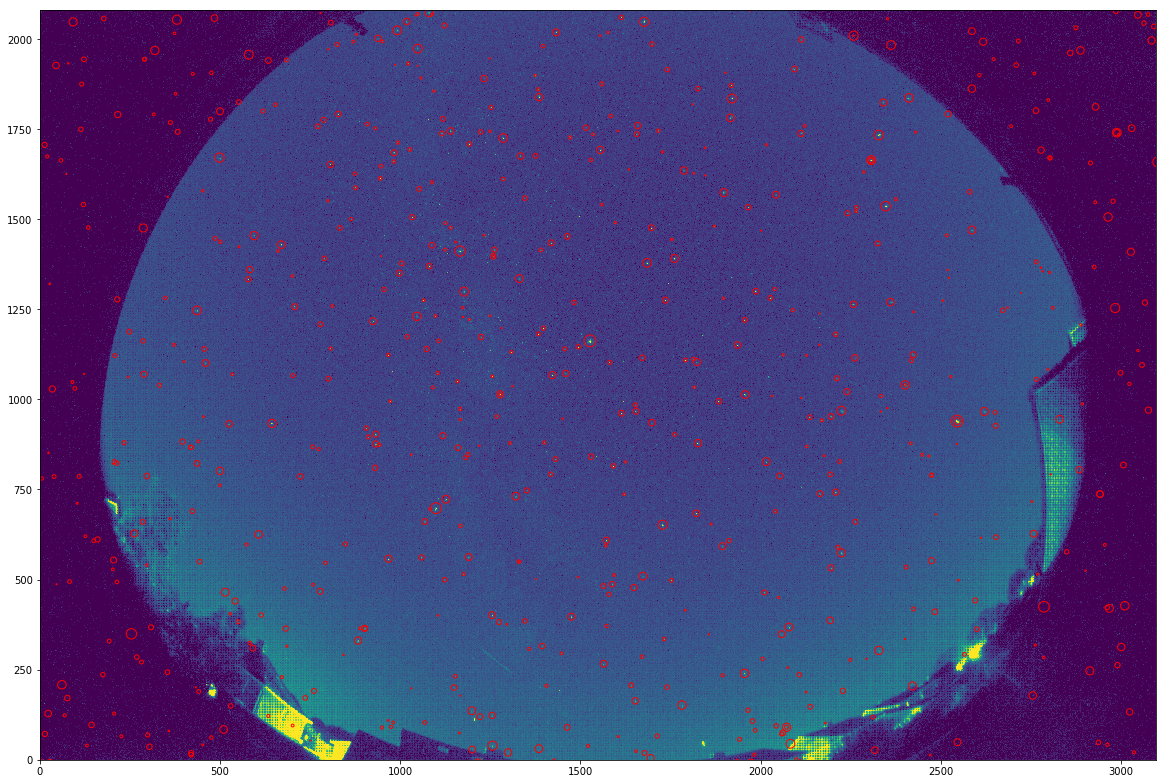

In [80]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(np.flipud(img), origin="lower")

ax.scatter(xp, yp, s=rad, marker="o", color="r", facecolors="None")
ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])